In [ ]:
Preprocess of 2 datasets E

# Index

1. [Imports](#Imports)
2. [Dataset Importation](#Dataset-Importation)
3. [Data Exploration](#Data-Exploration)
4. [Data Cleaning](#Data-Cleaning)
5. [Sampling patients to reduce data size](#Sampling-patients-to-reduce-data-size)
   - [Checking distribution from original to sampled](#Checking-distribution-from-original-to-sampled)
   - [Final Patients](#Final-Patients)
6. [Preprocessing (patient data)](#Preprocessing-patient-data)
   - [Demographic Data](#Demographic-Data)
7. [Creating the Data Set (Images)](#Creating-the-Data-Set-Images)
     - [Preprocess images](#Preprocess-images)
     - [Split the data](#Split-the-data)
7. [Data Augmentation for Training and Validation](#Data-Augmentation-for-Training-and-Validation)
   - [Visualizing the final augmented images and the bboxes](#Visualizing-the-final-augmented-images-and-the-bboxes)
   - [Dataset](#Dataset)

## Imports

In [1]:
# OS and File Management
import os
import shutil
import random
from glob import glob
import pickle
import xml.etree.ElementTree as ET
import re

# Scientific Computing and Data Processing
import numpy as np
import pandas as pd

# Image Processing and Augmentation
import cv2
import pydicom
import albumentations as A
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, Affine,
    GaussianBlur, CLAHE, RandomGamma, GaussNoise
)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Custom Utilities
from VisualizationTools.get_data_from_XML import XML_preprocessor, get_category
from VisualizationTools.get_gt import get_gt
from VisualizationTools.getUID import getUID_path
from VisualizationTools.utils import loadFileInformation
from functions_DataPreprocessing import *

/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Dataset Importation

In [2]:
df = pd.read_excel('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/statistics_clinical.xlsx')

### Creating the Data Set (Images)

#### Split the data
* Data was splited **70% train, 15% val, 15% test**

In [30]:
input_dir = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'YOLO 2datasets E')
output_dir = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split patient 2datasets E')

In [33]:
import os
from collections import defaultdict

def extract_patient_id(filename):
    """Extracts the patient ID from filenames starting with E_LUNG1 or G_LUNG1."""
    parts = filename.split("_")
    if len(parts) > 1 and parts[0] in ["E", "G"] and parts[1].startswith("LUNG1-"):
        return f"{parts[0]}_{parts[1]}"  # Returns 'E_LUNG1-001' or 'G_LUNG1-002'
    return None  # Ignore other filenames

def count_images_labels_patients_by_class(base_directory):
    def analyze_folder(folder):
        counts_by_class = defaultdict(int)
        unique_patient_ids = defaultdict(set)

        if not os.path.isdir(folder):
            return counts_by_class, unique_patient_ids  # Return empty if folder doesn't exist

        for file in os.listdir(folder):
            if os.path.isfile(os.path.join(folder, file)):
                patient_id = extract_patient_id(file)  # Extract patient ID
                
                if patient_id:
                    first_letter = patient_id[0]  # 'E' or 'G'
                    counts_by_class[first_letter] += 1
                    unique_patient_ids[first_letter].add(patient_id)  # Store unique patient IDs

        return counts_by_class, unique_patient_ids

    # Define dataset splits
    splits = ["train", "val", "test"]
    total_counts = defaultdict(lambda: {"images": 0, "labels": 0, "patients": set()})

    for split in splits:
        images_folder = os.path.join(base_directory, split, "images")
        labels_folder = os.path.join(base_directory, split, "labels")

        # Analyze images and labels per split
        images_counts, images_patient_ids = analyze_folder(images_folder)
        labels_counts, labels_patient_ids = analyze_folder(labels_folder)

        # Aggregate counts across all splits
        for letter in ['E', 'G']:
            total_counts[letter]["images"] += images_counts.get(letter, 0)
            total_counts[letter]["labels"] += labels_counts.get(letter, 0)
            total_counts[letter]["patients"].update(images_patient_ids[letter].union(labels_patient_ids[letter]))

    # Convert patient sets to counts
    for letter in ['E', 'G']:
        total_counts[letter]["patients"] = len(total_counts[letter]["patients"])

    return total_counts

# Example usage
base_directory = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split patient E') # Replace with actual dataset path
class_counts = count_images_labels_patients_by_class(base_directory)

# Print results
print("Final Class Counts (Aggregated Across Train, Val, Test):")
print(class_counts)

Final Class Counts (Aggregated Across Train, Val, Test):
defaultdict(<function count_images_labels_patients_by_class.<locals>.<lambda> at 0x3124b9bc0>, {'E': {'images': 2026, 'labels': 2026, 'patients': 114}, 'G': {'images': 512, 'labels': 512, 'patients': 56}})


In [34]:
import os
import re
from collections import defaultdict

def extract_patient_id(filename):
    """Extracts the patient ID in the format LUNG1-XXX for class G."""
    match = re.search(r"G_LUNG1-\d+", filename)  # Match pattern for G_LUNG1-XXX
    if match:
        return match.group()  # Return the matched patient ID
    return None  # Ignore other filenames

def get_unique_patients_by_class(base_directory, target_class="G"):
    def analyze_folder(folder):
        unique_patient_ids = set()

        if not os.path.isdir(folder):
            return unique_patient_ids  # Return empty if folder doesn't exist

        for file in os.listdir(folder):
            if os.path.isfile(os.path.join(folder, file)):
                patient_id = extract_patient_id(file)  # Extract patient ID
                
                if patient_id:
                    unique_patient_ids.add(patient_id)  # Store unique patient ID

        return unique_patient_ids

    # Define dataset splits
    splits = ["train", "val", "test"]
    total_unique_patients = set()

    for split in splits:
        images_folder = os.path.join(base_directory, split, "images")
        labels_folder = os.path.join(base_directory, split, "labels")

        # Aggregate unique patient IDs across images and labels
        total_unique_patients.update(analyze_folder(images_folder))
        total_unique_patients.update(analyze_folder(labels_folder))

    return sorted(total_unique_patients)  # Return sorted list of unique patient IDs

# Example usage
unique_G_patients = get_unique_patients_by_class(base_directory, target_class="G")

# Print results
print("Unique Patient IDs for Class G:")
print(unique_G_patients)


Unique Patient IDs for Class G:
['G_LUNG1-007', 'G_LUNG1-010', 'G_LUNG1-014', 'G_LUNG1-027', 'G_LUNG1-050', 'G_LUNG1-061', 'G_LUNG1-063', 'G_LUNG1-064', 'G_LUNG1-078', 'G_LUNG1-082', 'G_LUNG1-086', 'G_LUNG1-098', 'G_LUNG1-122', 'G_LUNG1-135', 'G_LUNG1-145', 'G_LUNG1-146', 'G_LUNG1-150', 'G_LUNG1-167', 'G_LUNG1-202', 'G_LUNG1-206', 'G_LUNG1-222', 'G_LUNG1-253', 'G_LUNG1-264', 'G_LUNG1-266', 'G_LUNG1-295', 'G_LUNG1-296', 'G_LUNG1-302', 'G_LUNG1-321', 'G_LUNG1-325', 'G_LUNG1-326', 'G_LUNG1-329', 'G_LUNG1-334', 'G_LUNG1-339', 'G_LUNG1-346', 'G_LUNG1-347', 'G_LUNG1-355', 'G_LUNG1-356', 'G_LUNG1-358', 'G_LUNG1-359', 'G_LUNG1-362', 'G_LUNG1-365', 'G_LUNG1-366', 'G_LUNG1-369', 'G_LUNG1-371', 'G_LUNG1-374', 'G_LUNG1-378', 'G_LUNG1-379', 'G_LUNG1-380', 'G_LUNG1-383', 'G_LUNG1-386', 'G_LUNG1-389', 'G_LUNG1-391', 'G_LUNG1-399', 'G_LUNG1-404', 'G_LUNG1-413', 'G_LUNG1-420']


In [45]:
import os
import shutil
from collections import defaultdict
from random import shuffle

def extract_patient_id(filename):
    """Extracts the patient ID from filename, handling both naming conventions."""
    parts = filename.split("_")
    if len(parts) > 1 and parts[1].startswith("LUNG1-"):
        return f"{filename[:1]}_{parts[1]}"  # Extracts patient ID for format: E_LUNG1-001
    else:
        return parts[0]  # Extracts patient ID for format: E001

def split_data_2datasets(input_dir, output_dir, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    """
    Splits preprocessed data into train, validation, and test sets based on the total number of images,
    while ensuring all images from a single patient are in the same set.
    """
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum up to 1."

    image_dir = os.path.join(input_dir, "images")
    label_dir = os.path.join(input_dir, "labels")

    # Group images by patient ID and class (first letter represents histology class)
    patient_to_files = defaultdict(list)
    patient_to_class = {}

    for image_file in os.listdir(image_dir):
        if image_file.endswith(".jpg"):
            patient_id = extract_patient_id(image_file)  # Extracts patient ID correctly
            patient_class = image_file[0]  # First letter represents histology class
            label_file = image_file.replace(".jpg", ".txt")
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, label_file)

            if os.path.exists(label_path):
                patient_to_files[patient_id].append((image_path, label_path))
                patient_to_class[patient_id] = patient_class

    # Group patients by class
    class_to_patients = defaultdict(list)
    explicit_e_patients = set()  # Stores explicitly assigned E001-E005 patients
    lung_e_patients = []  # Stores LUNG1- patients from class E

    for patient_id, patient_class in patient_to_class.items():
        if patient_class == "E":
            if patient_id in ["E0001", "E0002", "E0003", "E0004", "E0005"]:
                explicit_e_patients.add(patient_id)
            else:
                lung_e_patients.append(patient_id)  # Handle E_LUNG1-* patients
        else:
            class_to_patients[patient_class].append(patient_id)

    # Shuffle patients within each class for randomness
    for patient_list in class_to_patients.values():
        shuffle(patient_list)
    shuffle(lung_e_patients)

    # Split patients into train, validation, and test sets
    train_patients, val_patients, test_patients = set(), set(), set()

    # Explicitly allocate patients from class E (E001-E005)
    train_patients.update(["E0001", "E0002", "E0004"])
    val_patients.add("E0003")
    test_patients.add("E0005")

    # General splitting for all other classes, including E_LUNG1-* patients
    for patient_class, patients in class_to_patients.items():
        num_patients = len(patients)
        train_end = int(num_patients * train_ratio)
        val_end = train_end + int(num_patients * val_ratio)

        train_patients.update(patients[:train_end])
        val_patients.update(patients[train_end:val_end])
        test_patients.update(patients[val_end:])

    # Split `E_LUNG1-*` patients normally like A, B, and G
    num_lung_e = len(lung_e_patients)
    train_end = int(num_lung_e * train_ratio)
    val_end = train_end + int(num_lung_e * val_ratio)

    train_patients.update(lung_e_patients[:train_end])
    val_patients.update(lung_e_patients[train_end:val_end])
    test_patients.update(lung_e_patients[val_end:])

    # Ensure no overlap between sets
    assert train_patients.isdisjoint(val_patients), "Train and validation sets overlap."
    assert train_patients.isdisjoint(test_patients), "Train and test sets overlap."
    assert val_patients.isdisjoint(test_patients), "Validation and test sets overlap."

    # Collect files for each set
    train_files = [file for patient in train_patients for file in patient_to_files.get(patient, [])]
    test_files = [file for patient in val_patients for file in patient_to_files.get(patient, [])]
    val_files = [file for patient in test_patients for file in patient_to_files.get(patient, [])]

    # Helper function to copy files
    def copy_files(file_list, subset_name):
        subset_image_dir = os.path.join(output_dir, subset_name, "images")
        subset_label_dir = os.path.join(output_dir, subset_name, "labels")
        os.makedirs(subset_image_dir, exist_ok=True)
        os.makedirs(subset_label_dir, exist_ok=True)

        for image_path, label_path in file_list:
            shutil.copy(image_path, subset_image_dir)
            shutil.copy(label_path, subset_label_dir)

    # Copy files to their respective directories
    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

    print("Data split completed:")
    print(f"  Train set: {len(train_files)} samples ({len(train_patients)} patients)")
    print(f"  Validation set: {len(val_files)} samples ({len(val_patients)} patients)")
    print(f"  Test set: {len(test_files)} samples ({len(test_patients)} patients)")

'''_______________________________________________________________________________________________________________'''

import os
import re
from collections import defaultdict

def extract_patient_id(filename):
    """Extracts the patient ID while maintaining the correct format."""
    match = re.match(r"(E_LUNG1-\d+|G_LUNG1-\d+|E\d+|G\d+|A\d+|B\d+)", filename)  
    return match.group() if match else None  # Return matched patient ID

def count_images_labels_patients_by_class(output_directory):
    def analyze_folder(folder):
        counts_by_class = defaultdict(int)
        unique_patient_ids = defaultdict(set)
        dataset_patient_counts = defaultdict(lambda: defaultdict(set))  # {class: {dataset_type: {patients}}}

        if not os.path.isdir(folder):
            return counts_by_class, unique_patient_ids, dataset_patient_counts  # Return empty if folder doesn't exist

        for file in os.listdir(folder):
            if os.path.isfile(os.path.join(folder, file)):
                patient_id = extract_patient_id(file)  # Extract patient ID
                
                if patient_id:
                    class_label = patient_id[0]  # First letter (A, B, E, G)
                    dataset_label = "LUNG1" if "LUNG1" in patient_id else "Standard"  # Separate E_LUNG1 and G_LUNG1
                    
                    counts_by_class[class_label] += 1
                    unique_patient_ids[class_label].add(patient_id)  # Store unique patient IDs
                    dataset_patient_counts[class_label][dataset_label].add(patient_id)  # Store by dataset type

        return counts_by_class, unique_patient_ids, dataset_patient_counts

    # Define paths for images and labels folders
    images_folder = os.path.join(output_directory, "images")
    labels_folder = os.path.join(output_directory, "labels")

    if not os.path.isdir(images_folder):
        raise FileNotFoundError(f"Images folder not found in {output_directory}")
    if not os.path.isdir(labels_folder):
        raise FileNotFoundError(f"Labels folder not found in {output_directory}")

    # Analyze images and labels
    images_counts, images_patient_ids, images_dataset_counts = analyze_folder(images_folder)
    labels_counts, labels_patient_ids, labels_dataset_counts = analyze_folder(labels_folder)

    # Combine results
    class_counts = {}
    patient_ids = {}

    for letter in set(images_counts.keys()).union(labels_counts.keys()):
        class_counts[letter] = {
            "images": images_counts.get(letter, 0),
            "labels": labels_counts.get(letter, 0),
            "total_patients": len(images_patient_ids[letter].union(labels_patient_ids[letter])),
            "patients_standard": len(images_dataset_counts[letter]["Standard"].union(labels_dataset_counts[letter]["Standard"])),
            "patients_lung1": len(images_dataset_counts[letter]["LUNG1"].union(labels_dataset_counts[letter]["LUNG1"]))
        }

        patient_ids[letter] = {
            "all": sorted(images_patient_ids[letter].union(labels_patient_ids[letter])),
            "standard": sorted(images_dataset_counts[letter]["Standard"].union(labels_dataset_counts[letter]["Standard"])),
            "lung1": sorted(images_dataset_counts[letter]["LUNG1"].union(labels_dataset_counts[letter]["LUNG1"]))
        }

    return class_counts, patient_ids

##### **Train Data (70%)**

In [50]:
split_dir_train = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split patient E', 'train')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir_train)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")
    print(f"  - {counts['patients_standard']} LUNG-PET-CX patients")
    print(f"  - {counts['patients_lung1']} LUNG1 patients")

print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id} (All patients): {ids['all']}")
    print(f"Class {class_id} (LUNG-PET-CX patients): {ids['standard']}")
    print(f"Class {class_id} (LUNG1 patients): {ids['lung1']}")

Counts of images, labels, and patients by class:
Class A: 2546 images, 2546 labels, 59 unique patients
  - 59 LUNG-PET-CX patients
  - 0 LUNG1 patients
Class E: 1455 images, 1455 labels, 82 unique patients
  - 3 LUNG-PET-CX patients
  - 79 LUNG1 patients
Class G: 2935 images, 2935 labels, 68 unique patients
  - 29 LUNG-PET-CX patients
  - 39 LUNG1 patients
Class B: 2303 images, 2303 labels, 27 unique patients
  - 27 LUNG-PET-CX patients
  - 0 LUNG1 patients

List of unique patient IDs by class:
Class A (All patients): ['A0001', 'A0003', 'A0005', 'A0006', 'A0008', 'A0012', 'A0014', 'A0016', 'A0017', 'A0024', 'A0026', 'A0027', 'A0029', 'A0030', 'A0032', 'A0036', 'A0037', 'A0039', 'A0042', 'A0044', 'A0045', 'A0047', 'A0048', 'A0051', 'A0057', 'A0061', 'A0066', 'A0068', 'A0073', 'A0075', 'A0077', 'A0089', 'A0091', 'A0092', 'A0095', 'A0103', 'A0105', 'A0106', 'A0108', 'A0112', 'A0118', 'A0120', 'A0121', 'A0125', 'A0128', 'A0132', 'A0137', 'A0140', 'A0147', 'A0157', 'A0160', 'A0168', 'A0170'

##### **Validation Data (15%)**

In [51]:
split_dir_train = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split patient E', 'val')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir_train)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")
    print(f"  - {counts['patients_standard']} LUNG-PET-CX patients")
    print(f"  - {counts['patients_lung1']} LUNG1 patients")

print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id} (All patients): {ids['all']}")
    print(f"Class {class_id} (LUNG-PET-CX patients): {ids['standard']}")
    print(f"Class {class_id} (LUNG1 patients): {ids['lung1']}")

Counts of images, labels, and patients by class:
Class A: 508 images, 508 labels, 10 unique patients
  - 10 LUNG-PET-CX patients
  - 0 LUNG1 patients
Class E: 470 images, 470 labels, 19 unique patients
  - 1 LUNG-PET-CX patients
  - 18 LUNG1 patients
Class G: 497 images, 497 labels, 12 unique patients
  - 4 LUNG-PET-CX patients
  - 8 LUNG1 patients
Class B: 364 images, 364 labels, 5 unique patients
  - 5 LUNG-PET-CX patients
  - 0 LUNG1 patients

List of unique patient IDs by class:
Class A (All patients): ['A0010', 'A0013', 'A0019', 'A0021', 'A0022', 'A0086', 'A0149', 'A0162', 'A0169', 'A0183']
Class A (LUNG-PET-CX patients): ['A0010', 'A0013', 'A0019', 'A0021', 'A0022', 'A0086', 'A0149', 'A0162', 'A0169', 'A0183']
Class A (LUNG1 patients): []
Class E (All patients): ['E0003', 'E_LUNG1-017', 'E_LUNG1-040', 'E_LUNG1-043', 'E_LUNG1-077', 'E_LUNG1-113', 'E_LUNG1-124', 'E_LUNG1-140', 'E_LUNG1-142', 'E_LUNG1-172', 'E_LUNG1-182', 'E_LUNG1-191', 'E_LUNG1-254', 'E_LUNG1-262', 'E_LUNG1-267', '

##### **Test Data (15%)**

In [52]:
split_dir_train = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split patient E', 'test')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir_train)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")
    print(f"  - {counts['patients_standard']} LUNG-PET-CX patients")
    print(f"  - {counts['patients_lung1']} LUNG1 patients")

print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id} (All patients): {ids['all']}")
    print(f"Class {class_id} (LUNG-PET-CX patients): {ids['standard']}")
    print(f"Class {class_id} (LUNG1 patients): {ids['lung1']}")

Counts of images, labels, and patients by class:
Class A: 475 images, 475 labels, 8 unique patients
  - 8 LUNG-PET-CX patients
  - 0 LUNG1 patients
Class E: 302 images, 302 labels, 18 unique patients
  - 1 LUNG-PET-CX patients
  - 17 LUNG1 patients
Class G: 556 images, 556 labels, 14 unique patients
  - 5 LUNG-PET-CX patients
  - 9 LUNG1 patients
Class B: 354 images, 354 labels, 5 unique patients
  - 5 LUNG-PET-CX patients
  - 0 LUNG1 patients

List of unique patient IDs by class:
Class A (All patients): ['A0053', 'A0059', 'A0097', 'A0109', 'A0135', 'A0163', 'A0184', 'A0187']
Class A (LUNG-PET-CX patients): ['A0053', 'A0059', 'A0097', 'A0109', 'A0135', 'A0163', 'A0184', 'A0187']
Class A (LUNG1 patients): []
Class E (All patients): ['E0005', 'E_LUNG1-003', 'E_LUNG1-029', 'E_LUNG1-055', 'E_LUNG1-058', 'E_LUNG1-084', 'E_LUNG1-119', 'E_LUNG1-165', 'E_LUNG1-170', 'E_LUNG1-188', 'E_LUNG1-216', 'E_LUNG1-227', 'E_LUNG1-235', 'E_LUNG1-248', 'E_LUNG1-277', 'E_LUNG1-294', 'E_LUNG1-308', 'E_LUNG1-

## Data Augmentation for Training and Validation

<span style="font-size:18px; font-weight:bold;">Purpose of Augmentation</span>  
Data augmentation is used to artificially expand the training dataset by applying transformations to existing images. This helps improve the model's generalization by exposing it to a variety of variations and preventing overfitting.  
<br>
<span style="font-size:18px; font-weight:bold;">Augmentation Strategies for Training</span>  
In the training dataset, different augmentation pipelines were applied to balance the class distribution and enhance the dataset's diversity. Special consideration was given to **Class E**, which had only **201 images** compared to the **other classes with over 3,000 images**. To account for this imbalance, **more intensive augmentations** were applied to Class E to generate a sufficient number of diverse samples.  
* All images were augmented until they **reached the same number of images as the class with the most images** (in this case until they reached **2566 images** - same number as the class G).  
<br>

<span style="font-size:16px; font-weight:bold;">Transformations Applied:</span>  
1. **Horizontal Flip**: Introduced variation by flipping images horizontally.  
2. **Random Brightness/Contrast**: Adjusted brightness and contrast to simulate different imaging conditions.  
3. **Affine Transformations**:  
   - Small translations (e.g., 1-2%) and scaling (e.g., 95%-105%).  
   - Slight rotations (e.g., -2° to 2°) to mimic slight misalignments.  
4. **Gaussian Blur**: Added blur to simulate lower-quality imaging conditions.  
5. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Enhanced local contrast in images.  
6. **Random Gamma Adjustments**: Adjusted image gamma to alter overall brightness.  

For Class E, the **intense augmentation pipeline** included:  
- Larger translations (5%-10%) and scaling variations (80%-120%).  
- More pronounced rotations (-10° to 10°) and shear transformations (-5° to 5°).  
- Increased blur and contrast adjustments to maximize variation.  
<br>

<span style="font-size:18px; font-weight:bold;">Contextual Considerations</span>  
Since the data consists of **CT/PET scans**, it was important to apply transformations that preserve the anatomical and diagnostic integrity of the images. For example:  
- **Rotations and translations** were kept small to avoid unrealistic spatial changes.  
- **Brightness/contrast adjustments** were restricted to values that align with possible differences in imaging modalities.  
- **Gaussian blur** and **CLAHE** simulated conditions such as scanner noise or imaging artifacts.  
<br>

<span style="font-size:18px; font-weight:bold;">Augmentation for Validation</span>  
For the validation dataset, fewer augmentations were applied to ensure that the data closely resembles real-world conditions. The augmentations for validation included:  
1. **Horizontal Flip (5%)**: Small chance of flipping for minor variation.  
2. **Random Brightness/Contrast (3%-5%)**: Simulated subtle differences in imaging conditions.  
3. **Affine Transformations**:  
   - Tiny translations (1%-2%) and scaling (95%-105%).  
   - Slight rotations (-2° to 2°).  
* All images were augmented until they **reached the same number of images as the class with the most images** (in this case until they reached **508 images** - same number as the class A).  
<br>

<span style="font-size:18px; font-weight:bold;">Rationale for Choosing Augmentations</span>  
- CT/PET scans are highly sensitive to transformations that distort anatomical features. Therefore, care was taken to ensure that augmentations like large rotations or extreme brightness changes were avoided.  
- **For training**: Aggressive augmentations were used for the underrepresented Class E to create enough diverse samples without straying too far from realistic imaging.  
- **For validation**: Minimal augmentations were applied to mimic real-world test data, ensuring the evaluation remained unbiased.


# I changed itr so the intense pipeline is for all

#### **Train**

In [17]:
input_dir_train= os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split patient E', 'train')
output_dir_train= os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split augmented E', 'train')

In [18]:
augment_yolo_images_train(input_dir_train, output_dir_train, 2950, target_size=(512, 512))


Augmentation completed.
  Total images for Class 0 after augmentation: 2950
  Total images for Class 1 after augmentation: 2950
  Total images for Class 2 after augmentation: 2950
  Total images for Class 3 after augmentation: 2950


In [19]:
split_dir = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split augmented E', 'train')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class A: 2950 images, 2950 labels, 59 unique patients

List of unique patient IDs by class:
Class E: 2950 images, 2950 labels, 82 unique patients

List of unique patient IDs by class:
Class G: 2950 images, 2950 labels, 68 unique patients

List of unique patient IDs by class:
Class B: 2950 images, 2950 labels, 27 unique patients

List of unique patient IDs by class:
Class A: ['A0001', 'A0003', 'A0005', 'A0006', 'A0008', 'A0012', 'A0014', 'A0016', 'A0017', 'A0024', 'A0026', 'A0027', 'A0029', 'A0030', 'A0032', 'A0036', 'A0037', 'A0039', 'A0042', 'A0044', 'A0045', 'A0047', 'A0048', 'A0051', 'A0057', 'A0061', 'A0066', 'A0068', 'A0073', 'A0075', 'A0077', 'A0089', 'A0091', 'A0092', 'A0095', 'A0103', 'A0105', 'A0106', 'A0108', 'A0112', 'A0118', 'A0120', 'A0121', 'A0125', 'A0128', 'A0132', 'A0137', 'A0140', 'A0147', 'A0157', 'A0160', 'A0168', 'A0170', 'A0171', 'A0179', 'A0182', 'A0185', 'A0189', 'A0192']
Class E: ['E0001', 'E0002', 'E0004', 'E_LU

#### **Validation**

In [20]:
input_dir_val= os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split patient E', 'val')
output_dir_val= os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split augmented E', 'val')

In [21]:
augment_yolo_images_val(input_dir_val, output_dir_val, 510, target_size=(512, 512))


Augmentation completed.
  Total images for Class 1 after augmentation: 510
  Total images for Class 3 after augmentation: 510
  Total images for Class 2 after augmentation: 510
  Total images for Class 0 after augmentation: 510


In [13]:
split_dir = os.path.join('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer', 'split augmented E', 'val')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class A: 510 images, 510 labels, 10 unique patients

List of unique patient IDs by class:
Class E: 510 images, 510 labels, 19 unique patients

List of unique patient IDs by class:
Class G: 510 images, 510 labels, 4 unique patients

List of unique patient IDs by class:
Class B: 510 images, 510 labels, 5 unique patients

List of unique patient IDs by class:
Class A: ['A0010', 'A0013', 'A0019', 'A0021', 'A0022', 'A0086', 'A0149', 'A0162', 'A0169', 'A0183']
Class E: ['E0003', 'E_LUNG1-017', 'E_LUNG1-040', 'E_LUNG1-043', 'E_LUNG1-077', 'E_LUNG1-113', 'E_LUNG1-124', 'E_LUNG1-140', 'E_LUNG1-142', 'E_LUNG1-172', 'E_LUNG1-182', 'E_LUNG1-191', 'E_LUNG1-254', 'E_LUNG1-262', 'E_LUNG1-267', 'E_LUNG1-275', 'E_LUNG1-281', 'E_LUNG1-291', 'E_LUNG1-330']
Class G: ['G0008', 'G0010', 'G0033', 'G0046']
Class B: ['B0020', 'B0024', 'B0025', 'B0027', 'B0034']


### Vizualizing the final augmented images and the bboxes

UID: A0048, Image: A0048_1.3.6.1.4.1.14519.5.2.1.6655.2359.897715722617202614438703143841.jpg


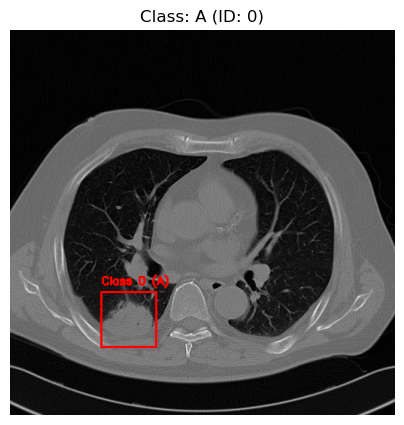

UID: A0103, Image: A0103_1.3.6.1.4.1.14519.5.2.1.6655.2359.177456888744910242069057314999.jpg


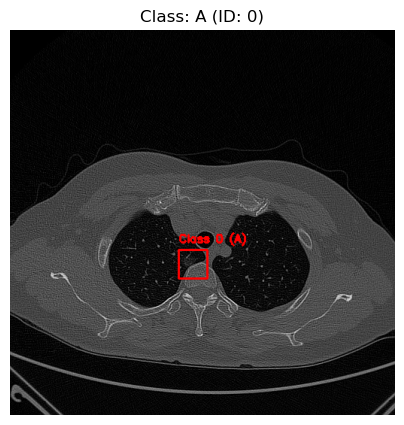

UID: G0011, Image: G0011_1.3.6.1.4.1.14519.5.2.1.6655.2359.153864141472614822083480497510.jpg


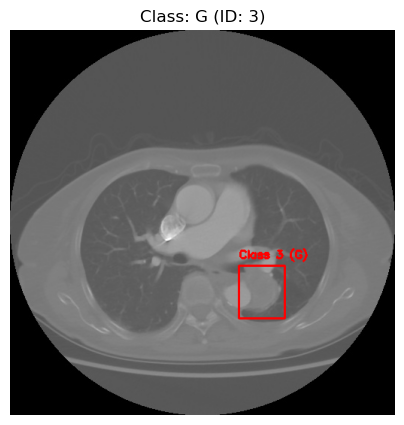

UID: E, Image: E_LUNG1-277_08-14-2008-StudyID-NA-12722_74_aug_106.jpg


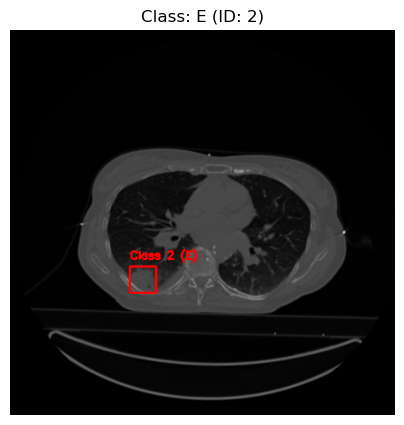

UID: G0050, Image: G0050_1.3.6.1.4.1.14519.5.2.1.6655.2359.184189013615126482915298044165_aug_51.jpg


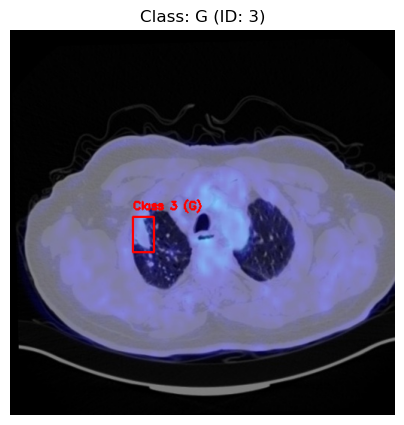

In [38]:
class_mapping = {
    "A": 0,  # Adenocarcinoma
    "B": 1,  # Small Cell Carcinoma
    "E": 2,  # Large Cell Carcinoma
    "G": 3   # Squamous Cell Carcinoma
}
visualize_yolo_images(split_dir, class_mapping, num_images=5)